## Первичный анализ

In [30]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
%%time
fn = './GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad'
adata = sc.read(fn)
print(adata)

AnnData object with n_obs × n_vars = 69249 × 129921
    obs: 'GEX_pct_counts_mt', 'GEX_n_counts', 'GEX_n_genes', 'GEX_size_factors', 'GEX_phase', 'ATAC_nCount_peaks', 'ATAC_atac_fragments', 'ATAC_reads_in_peaks_frac', 'ATAC_blacklist_fraction', 'ATAC_nucleosome_signal', 'cell_type', 'batch', 'ATAC_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
    var: 'feature_types', 'gene_id'
    uns: 'ATAC_gene_activity_var_names', 'dataset_id', 'genome', 'organism'
    obsm: 'ATAC_gene_activity', 'ATAC_lsi_full', 'ATAC_lsi_red', 'ATAC_umap', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'
CPU times: user 24.3 s, sys: 3.18 s, total: 27.4 s
Wall time: 28.2 s


In [32]:
import scipy.sparse as sp
from sklearn.utils.extmath import safe_sparse_dot

In [33]:
labels = adata.obs['cell_type']

In [34]:
X = adata.X

In [35]:
from scipy.sparse import csr_matrix

n, p = X.shape

mean = X.mean(axis=0).A1  

rows, cols = X.nonzero()
data_cen = X.data - mean[cols]
X_cen = csr_matrix((data_cen, (rows, cols)), shape=(n, p))

In [36]:
std = np.sqrt(X_cen.power(2).mean(axis=0)).A1
std[std == 0] = 1

Y_std = data_cen / std[cols]
Y = csr_matrix((Y_std, (rows, cols)), shape=X.shape)

In [37]:
Y.shape

(69249, 129921)

In [38]:
Z = np.load('Z.npy')
n, m = Z.shape

In [39]:
print(type(X))
print(type(Z))

<class 'scipy.sparse._csr.csr_matrix'>
<class 'numpy.ndarray'>


In [40]:
print(X.shape, Z.shape)

(69249, 129921) (67180, 3022)


## Корреляции признаков

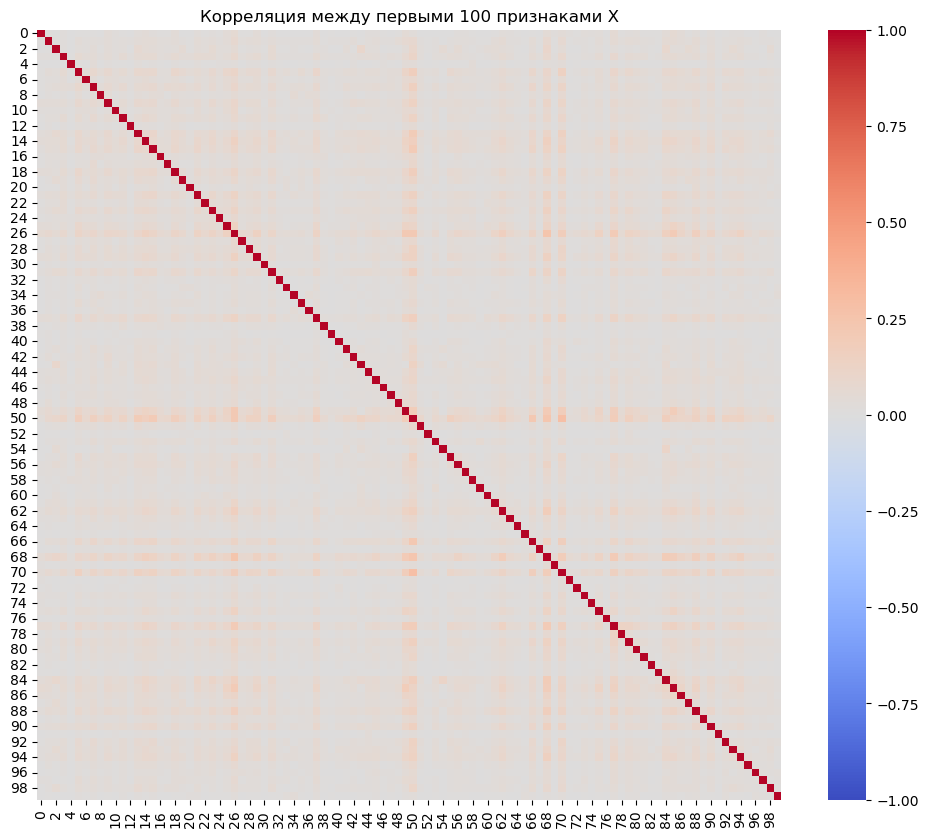

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

corr_X = cosine_similarity(X[:,:100].T)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_X, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Корреляция между первыми 100 признаками X')
plt.show()

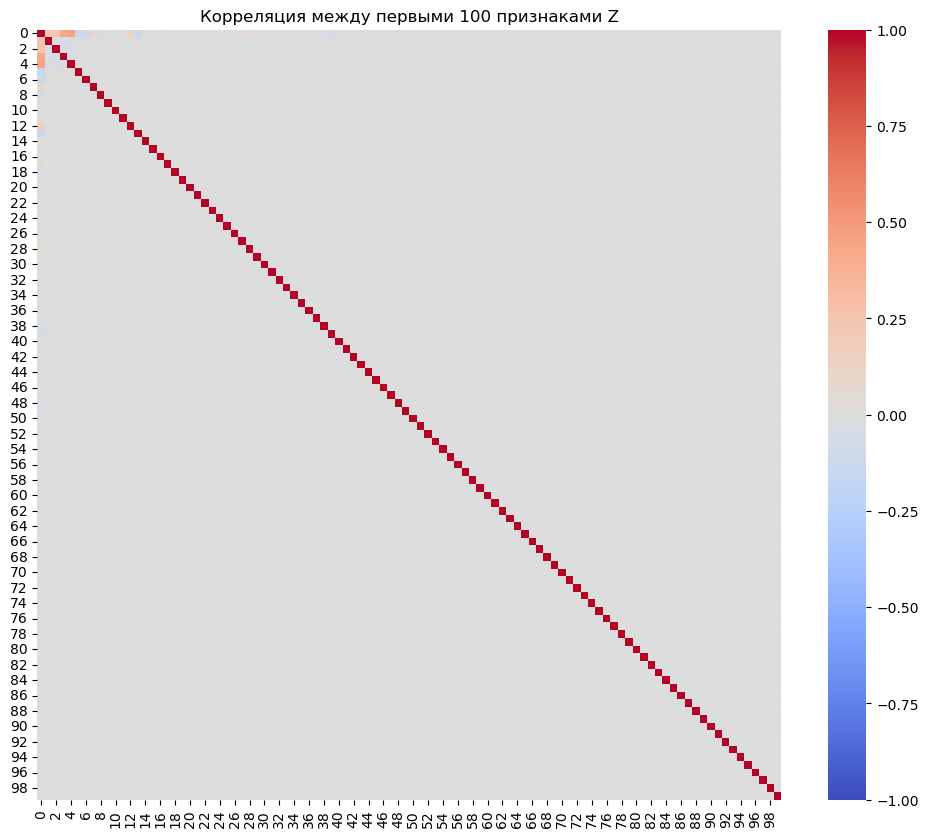

In [42]:
corr_Z = np.corrcoef(Z[:, :100].T)  

plt.figure(figsize=(12, 10))
sns.heatmap(corr_Z, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Корреляция между первыми 100 признаками Z')
plt.show()

In [43]:
type(labels)

pandas.core.series.Series

In [44]:
labels.shape

(69249,)

In [45]:
from sklearn.neighbors import LocalOutlierFactor
from scipy.sparse import issparse, csr_matrix

def remove_outliers_and_labels(adata, label_key='cell_type', n_top_genes=5000, n_pcs=50, n_neighbors=20, contamination='auto', copy=False):
    if copy:
        adata = adata.copy()
    
    if label_key not in adata.obs:
        raise ValueError(f"Label key '{label_key}' not found in adata.obs")
    
    original_X = adata.X
    labels = adata.obs[label_key].copy()
    
    adata_norm = adata.copy()
    sc.pp.filter_genes(adata_norm, min_cells=10)
    sc.pp.normalize_total(adata_norm, target_sum=1e4)
    sc.pp.log1p(adata_norm)
    
    sc.pp.highly_variable_genes(adata_norm, n_top_genes=n_top_genes, subset=True)
    sc.tl.pca(adata_norm, n_comps=n_pcs, svd_solver='arpack')
    
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    outliers = lof.fit_predict(adata_norm.obsm['X_pca']) == -1
    
    adata_filtered = adata[~outliers, :].copy()
    
    adata_filtered.X = original_X[~outliers, :]
    if issparse(original_X):
        adata_filtered.X = csr_matrix(adata_filtered.X) if not issparse(adata_filtered.X) else adata_filtered.X
    
    filtered_labels = labels[~outliers]
    
    print(f'Удалено {outliers.sum()} выбросов из {len(outliers)} клеток')
    print(f'Осталось {len(filtered_labels)} меток')
    
    return adata_filtered, filtered_labels

In [46]:
adata, labels = remove_outliers_and_labels(adata, label_key='cell_type', copy=True)

Удалено 2069 выбросов из 69249 клеток
Осталось 67180 меток


In [47]:
X = adata.X

In [48]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from tqdm import tqdm
import scipy.sparse

le = LabelEncoder()
y = le.fit_transform(labels)

def sparse_corr(X, y, n_feats=5000):
    """
    Вычисляет корреляции для первых n_feats признаков разреженной матрицы X и y
    """
    corrs = []
    X = X[:, :n_feats] if X.shape[1] > n_feats else X
    for i in tqdm(range(X.shape[1])):
        xi = X[:, i].toarray().ravel() if scipy.sparse.issparse(X) else X[:, i]
        corr = np.corrcoef(xi, y)[0, 1]
        corrs.append(corr)
    return np.nanmean(np.abs(corrs))

def dense_corr(Z, y):
    return np.nanmean([np.corrcoef(Z[:, i], y)[0, 1] for i in range(Z.shape[1])])

mean_corr_X = sparse_corr(X, y, n_feats=5000)  
mean_corr_Z = dense_corr(Z, y)

print(f"Mean correlation (X): {mean_corr_X:.4f}")
print(f"Mean correlation (Z): {mean_corr_Z:.4f}")


100%|███████████████████████████████████████| 5000/5000 [02:09<00:00, 38.72it/s]


Mean correlation (X): 0.0345
Mean correlation (Z): 0.0001


In [49]:
y_filtered = LabelEncoder().fit_transform(labels)

In [50]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

model = Ridge(alpha=1.0)
preds_Z = cross_val_predict(model, Z, y_filtered, cv=3)
mse_Z = mean_squared_error(y_filtered, preds_Z)

print(f"MSE (Z): {mse_Z:.4f}")


MSE (Z): 12.3354
